# Automatic OMA on shear frame (pregenerated data)

In [1]:
import koma.oma, koma.plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, welch, resample

import matplotlib.pyplot as plt

In [2]:
# Convenience functions
def plot_mode(ax, phi, first_dof_top=True, scaling=1.0):
    if first_dof_top:
        phi = np.flip(phi)
    
    phi_plot = np.hstack([0, phi])
    
    if scaling is not None:
        maxval = np.max(np.abs(np.real(phi_plot)))
        phi_plot = phi_plot/maxval * scaling

    handle = [None]*(levels+2)
    
    handle[0] = ax.plot(phi_plot-0.5, np.arange(0, levels+1, 1), color='black')[0]
    handle[1] = ax.plot(phi_plot+0.5, np.arange(0, levels+1, 1), color='black')[0]
    
    for level in range(1,levels+1):
        handle[level+1] = ax.plot([phi_plot[level]-0.5, phi_plot[level]+0.5], [level, level], color='black')[0]

    return handle

def plot_all_modes(levels, phi, phi_ref):
    # Mode shapes: simple plots
    fig, ax = plt.subplots(ncols=levels, nrows=1, sharey=True)
    for n in range(phi.shape[1]):
        max_true = np.argmax(np.abs(phi[:, n]))
        flip_factor = np.real(np.sign(phi[max_true, n]/phi_ref[max_true, n]))

        h2 = plot_mode(ax[n], phi_ref[:, n]*flip_factor)
        __ = [hi.set(alpha=1.0, color='gray', linestyle='-') for hi in h2]
        h1 = plot_mode(ax[n], phi[:, n])
        __ = [hi.set(alpha=1.0, color='red', linestyle='--') for hi in h1]

        ax[n].set_title(f'Mode {n+1}')
        
    ax[0].set_ylabel('Level')
    return fig, ax

## Load pregenerated data

In [3]:
data = np.load('./data/data_shearframe.npy')
fs = 12.0
tmax = 1200
t = np.arange(0, tmax, 1/fs)
levels = data.shape[1] #number of channels

# Load reference modal properties
omega_n_ref = np.load('./data/omega_n.npy')
xi_ref = np.load('./data/xi_ref.npy')
phi_ref = np.load('./data/phi_ref.npy')

## Define SSI parameters

In [4]:
i = 50
s = 3

orders_input = np.arange(2, 60+2, 2)
stabcrit = {'freq':0.05, 'damping': 0.2, 'mac': 0.2}

## Cov-SSI call

In [5]:
lambd, phi, orders = koma.oma.covssi(data, fs, i, orders_input) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, 
                                                                        stabcrit=stabcrit, 
                                                                        indicator='freq') # Stable poles

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


## Welch PSD estimate

In [6]:
nperseg = 1024
zp = 4
nfft = nperseg*zp

f, Pxx = welch(data[:,0], fs, 'hann', nperseg=nperseg, nfft=nfft)

## Visualization: stabilization plot

In [11]:
fig = koma.plot.stabplot(lambd_stab, orders_stab,  psd_freq=f*2*np.pi, psd_y=Pxx/np.pi/2, 
                         frequency_unit='rad/s', freq_range=[0,np.max(omega_n_ref)*1.2], damped_freq=False)
fig

FigureWidget({
    'data': [{'hovertemplate': '\\omega_n = %{x:.3f} rad/s<br>n = %{y}<br> %{text}',
              'marker': {'color': [#a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                                   #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9, #a9a9a9,
                    

# Pole clustering
By using pole clustering tecniques available in the `clustering` module, you can obtain modal results without any manual selection. The module is based on the HDBSCAN method, and relies on the `hdbscan` python package. The two cells below show how the module is used to automatically identify estimates of the three modes of ours system.

In [8]:
import koma.clustering

pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, 
                                               min_cluster_size=15, min_samples=15, 
                                               scaling={'mac':0.4, 'omega_n':0.8}, normalize_distances=False)
prob_threshold = 1.0   #probability of pole to belong to cluster, based on estimated "probability" density function

pole_clusterer.cluster()

# Establish clusters based on given prob_threshold
outputs = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = outputs 

# Group clusters in list
xi_auto, omega_n_auto, phi_auto, order_auto, ixs_auto, probs_auto = koma.clustering.group_clusters(*outputs)

# Establihs mean and stds of freqs and damping
xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi
xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

# Group only a selected quantity (e.g. indices) using the all_single_ix
grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)       # for instance the indices only,
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only
phi_mean = np.vstack([np.mean(phi_i, axis=1) for phi_i in grouped_phis]).T

In [12]:
# Print table
import pandas as pd
try:
    res_data = np.vstack([omega_n_ref/2/np.pi, xi_ref*100, fn_mean, 100*xi_mean, fn_std, 100*xi_std]).T
    res_exp = pd.DataFrame(res_data, columns=['$f_n$ (true) [Hz]', r'$\xi$ (true) [%]', '$f_n$ [Hz]', r'$\xi$ [%]', '$\\sigma_f$ [Hz]', r'$\\sigma_\xi$ [%]'])
    res_analytical = None
except:
    res_data = np.vstack([omega_n_ref/2/np.pi, xi_ref*100]).T
    res_analytical = pd.DataFrame(res_data,  columns=['$f_n$ (true) [Hz]', r'$\xi$ (true) [%]'])
    
    res_data = np.vstack([fn_mean, 100*xi_mean, fn_std, 100*xi_std]).T
    res_exp = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]', '$\\sigma_f$ [Hz]', r'$\\sigma_\xi$ [%]'])
    
display(res_exp)
display(res_analytical)

,$f_n$ (true) [Hz],$\xi$ (true) [%],$f_n$ [Hz],$\xi$ [%],$\sigma_f$ [Hz],$\\sigma_\xi$ [%]
0,0.18,4.39,0.18,5.70,0.00,0.72
1,0.53,1.50,0.52,1.23,0.00,0.01
2,0.83,0.95,0.82,0.96,0.00,0.01
3,1.07,0.74,1.04,0.73,0.00,0.00
4,1.22,0.65,1.18,0.79,0.00,0.01


None

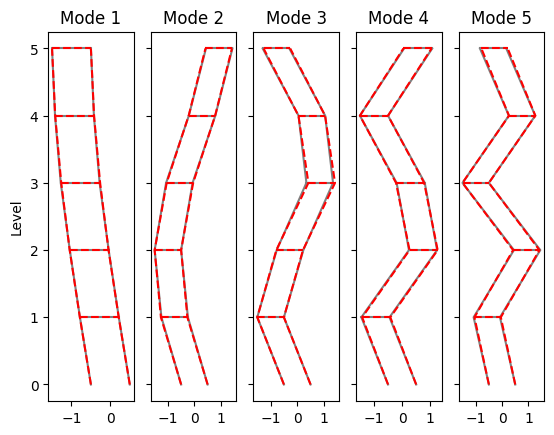

In [14]:
# For plot below poles with indices 1, 7, 19, 39, 69 are picked in plot above
# This differs from simulation to simulation due to the noise that is added.
fig, ax = plot_all_modes(levels, np.real(phi_ref), np.real(phi_mean))